In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from glob import glob
import xrft
%matplotlib inline

In [2]:
ds = xr.open_dataset('/data/scratch/rpa/LLC/netcdf_regions/LLC4320_0725_concat.nc')


In [3]:
figdir = 'figures4/'


In [4]:
u = ds.U.sel(X=ds.X.mean(), Y=ds.Y.mean(), method='nearest')
v = ds.V.sel(X=ds.X.mean(), Y=ds.Y.mean(), method='nearest')

In [5]:
w = (u + 1j * v)
dft = xrft.dft(w, dim=['time'] )
psd = (dft * np.conj(dft)).astype('f8')
winsize = int(len(psd)/500)
psd_smooth = psd.rolling(freq_time=winsize, center=True).mean(dim='freq_time')
#psd_ccw = psd_smooth.sel(freq_time=slice(0, np.inf)).rename('ccw').to_dataset()
#psd_cw = psd_smooth.sel(freq_time=slice(-np.inf, 0)).rename('cw').to_dataset()

psd_ccw = psd_smooth.sel(freq_time=slice(0, np.inf)).rename('ccw')
psd_cw = psd_smooth.sel(freq_time=slice(-np.inf, 0)).rename('cw')

psd_cw.freq_time.data *= -1


/usr/local/anaconda/lib/python2.7/site-packages/xarray/core/ops.py:202: ComplexWarning: Casting complex values to real discards the imaginary part
  return method(*args, **kwargs)


In [6]:
ylim=[1e-4,1e4]
xlim=[3e-7, 1e-4]

/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


ValueError: Data has no positive values, and therefore can not be log-scaled.

Error in callback <function post_execute at 0x7f71340d91b8> (for post_execute):


ValueError: Data has no positive values, and therefore can not be log-scaled.

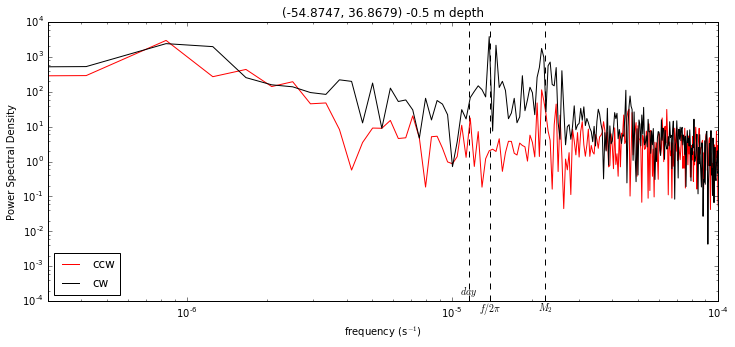

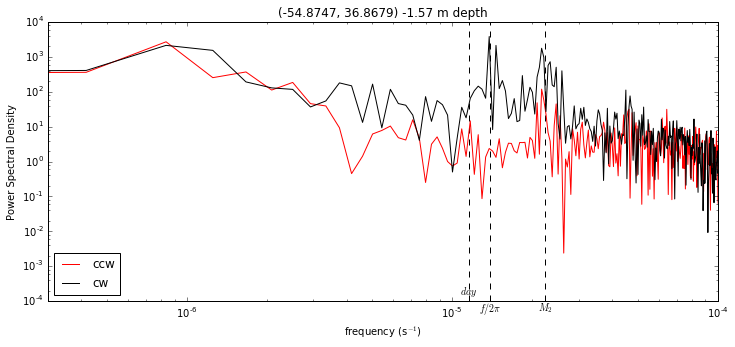

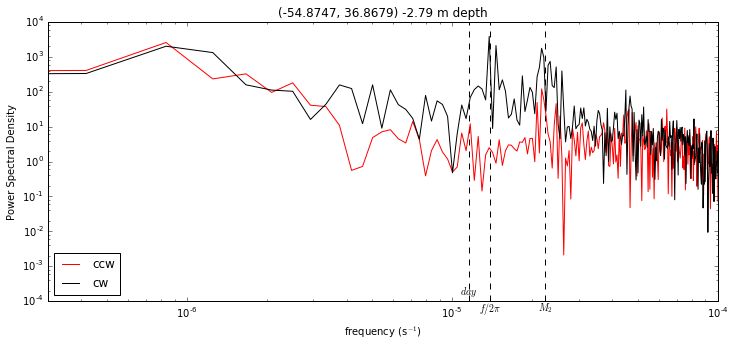

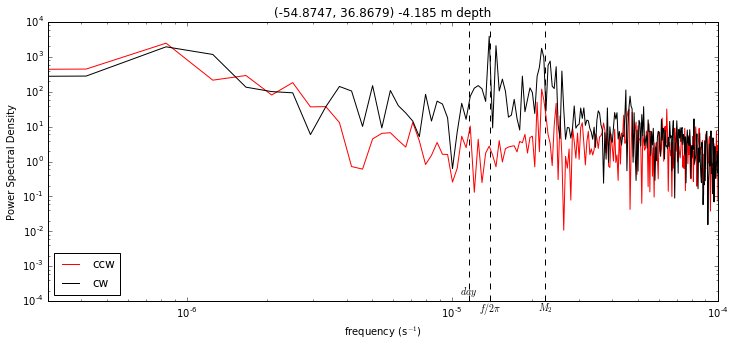

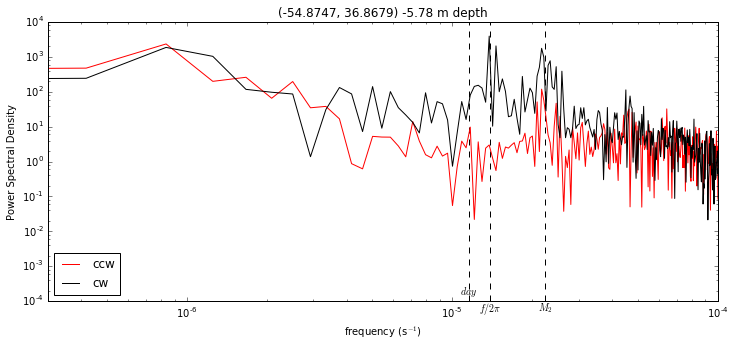

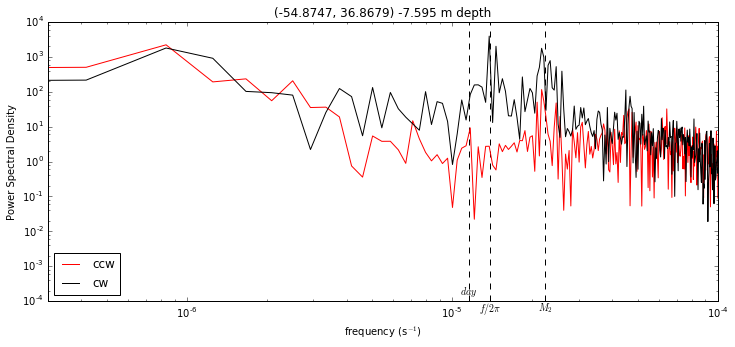

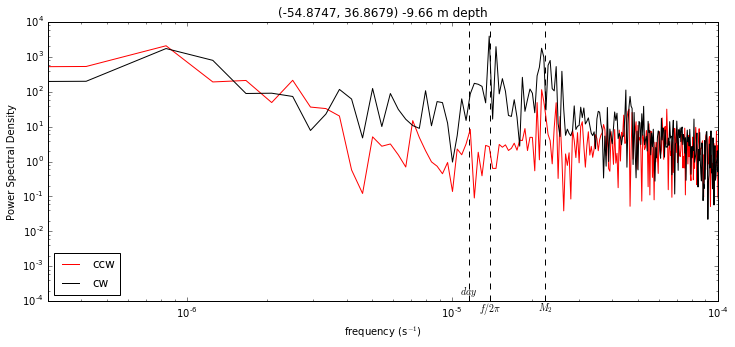

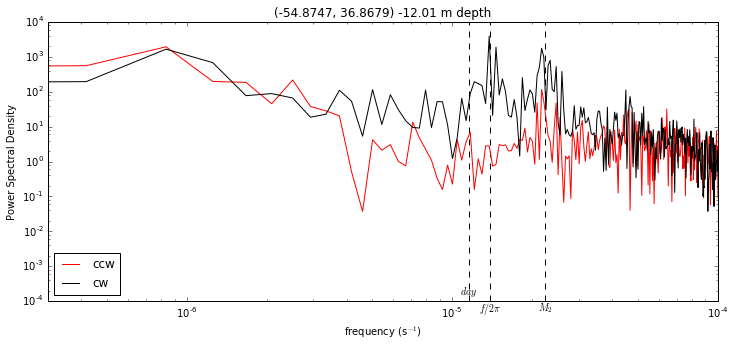

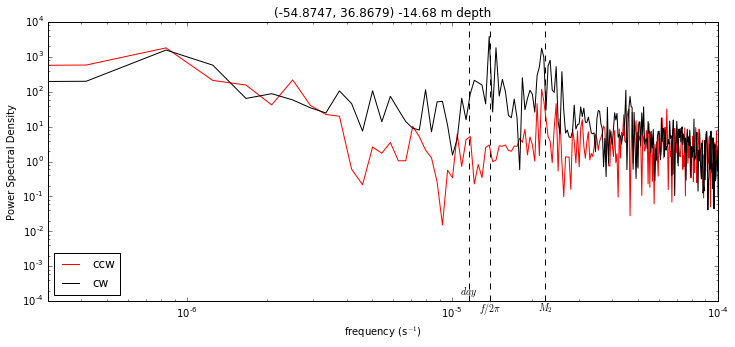

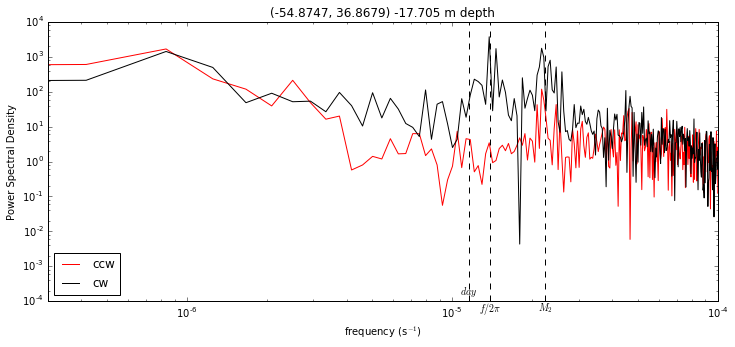

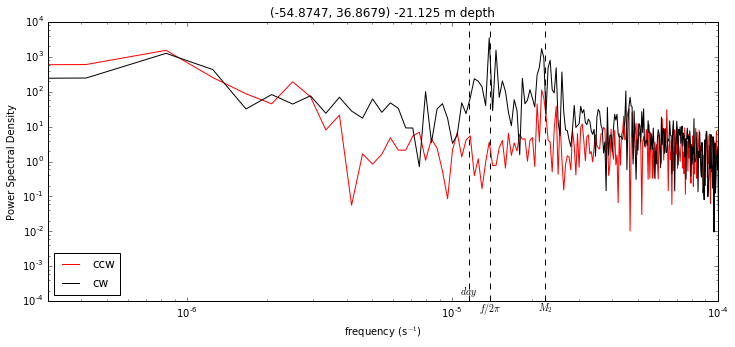

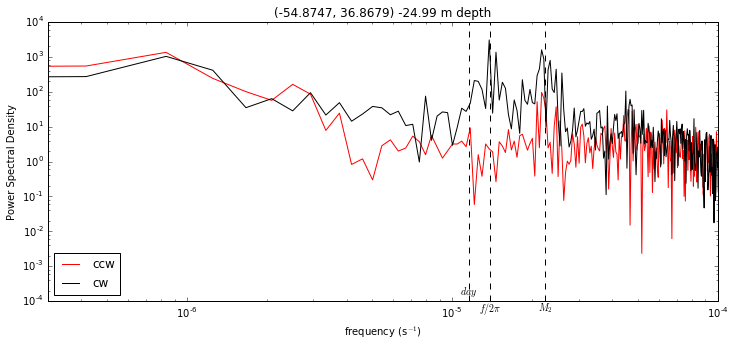

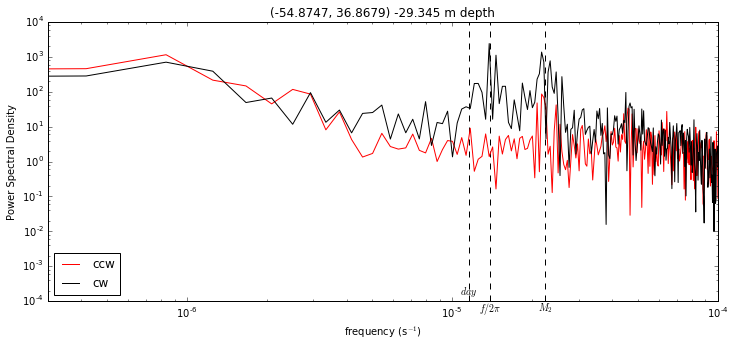

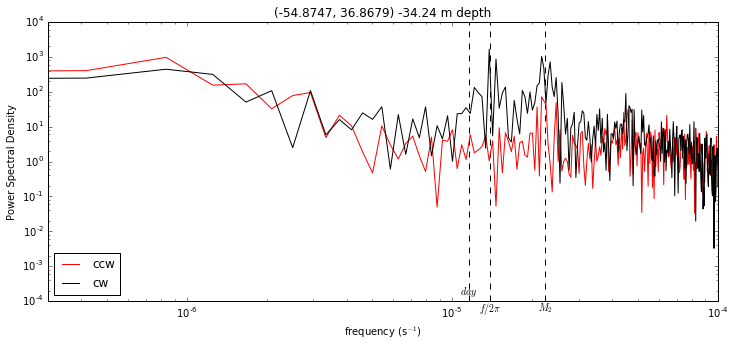

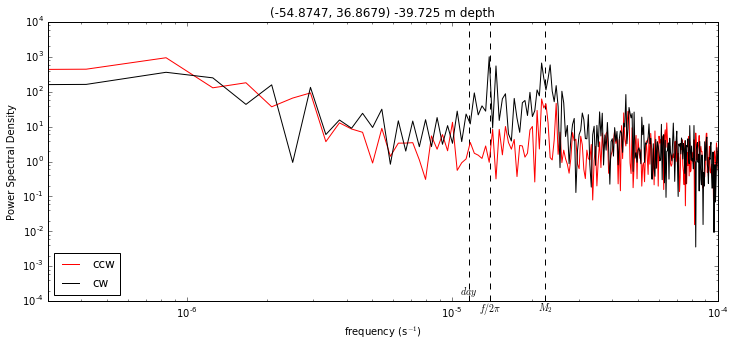

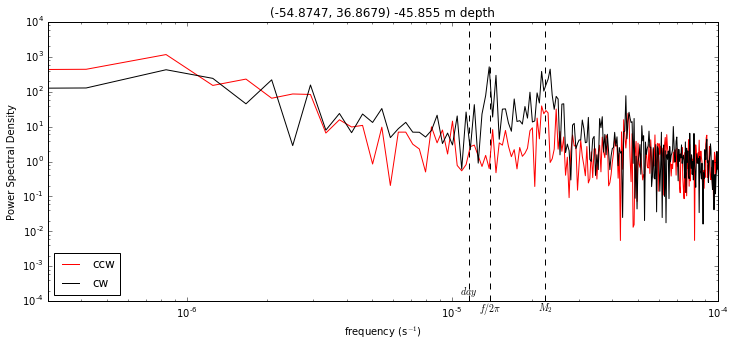

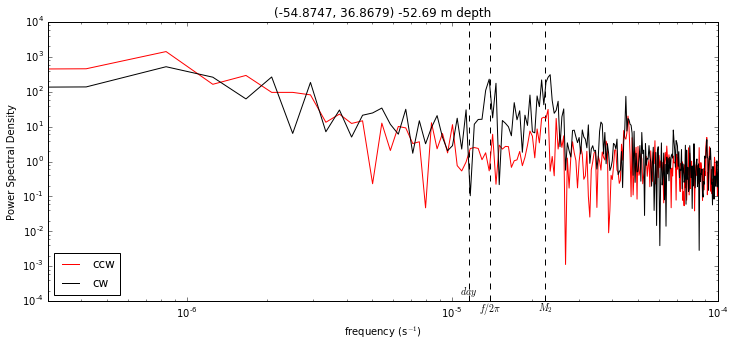

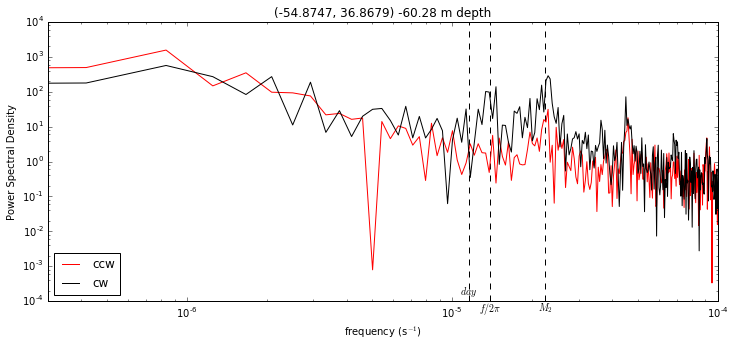

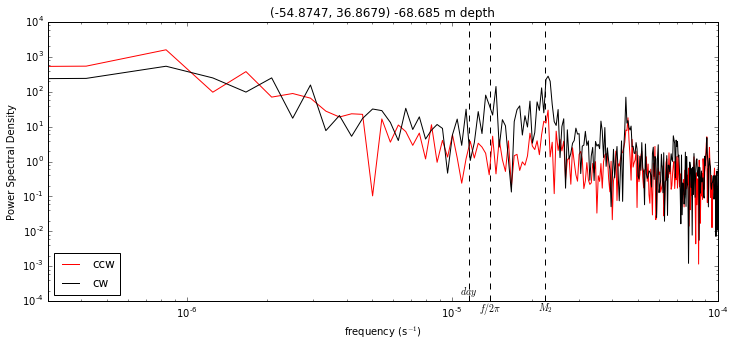

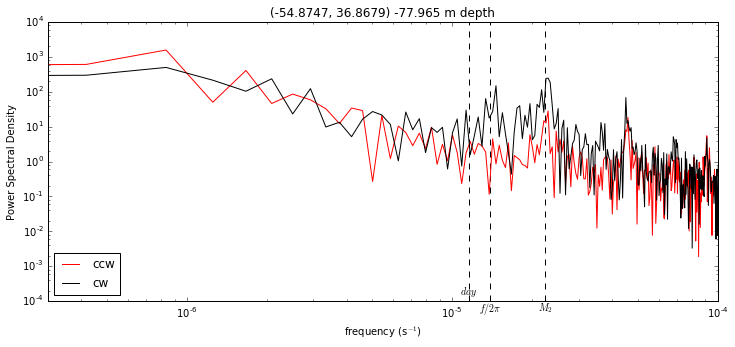

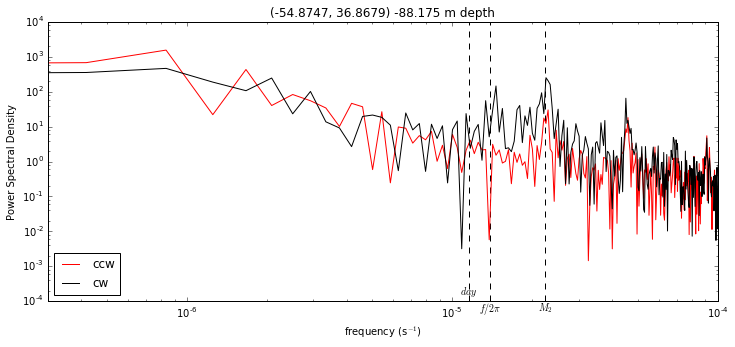

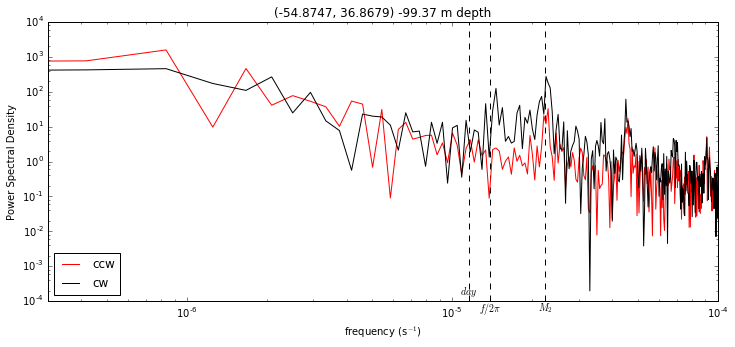

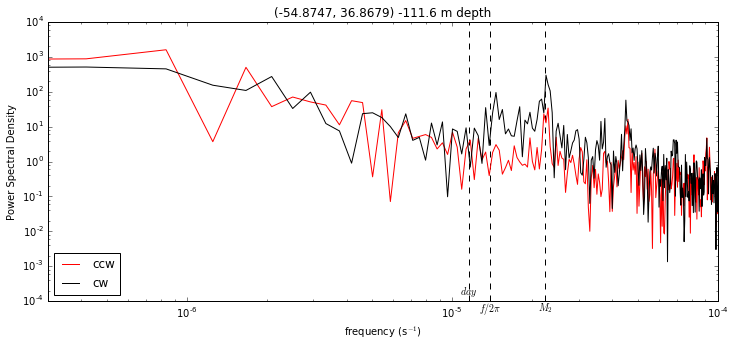

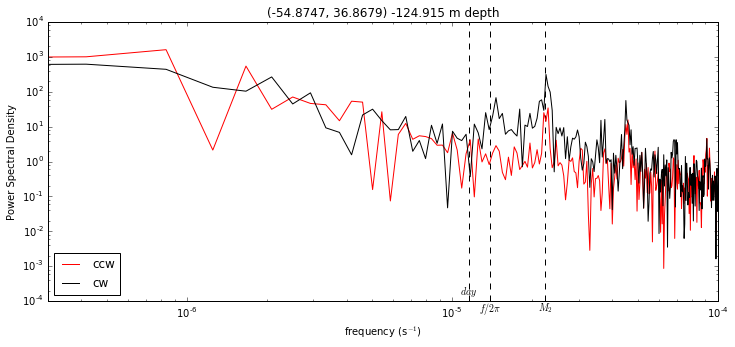

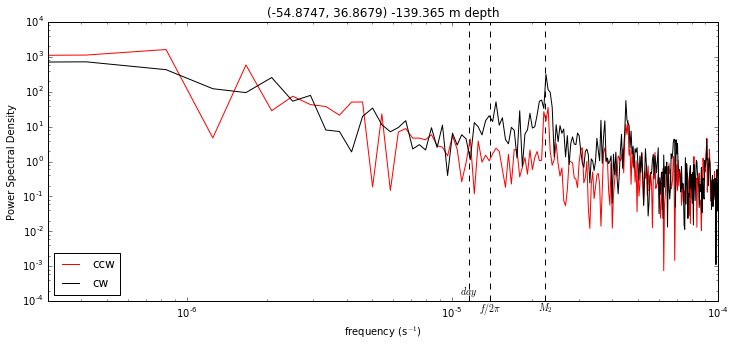

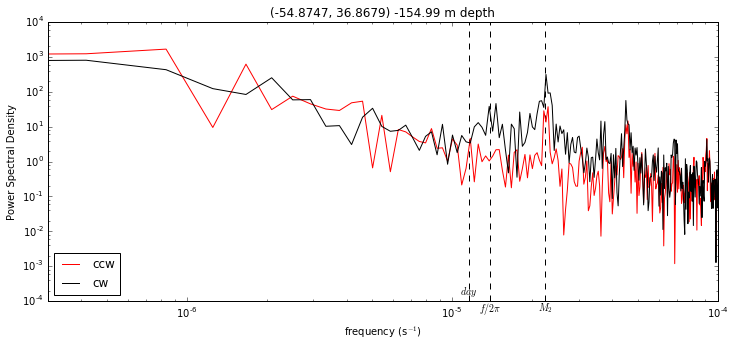

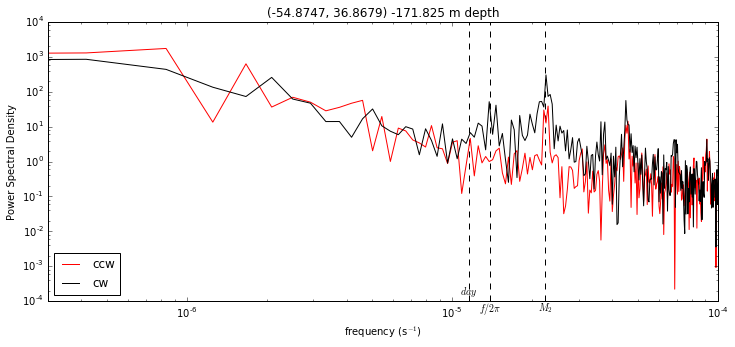

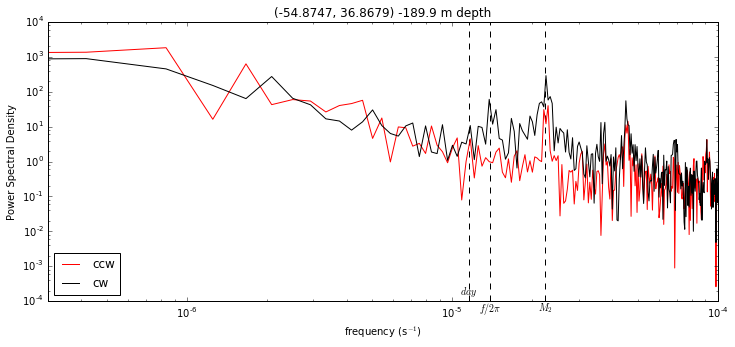

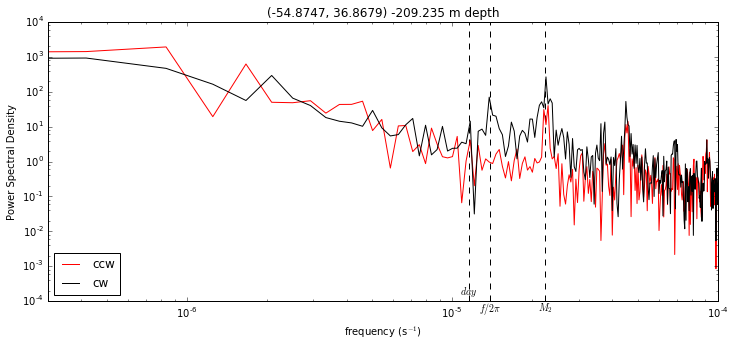

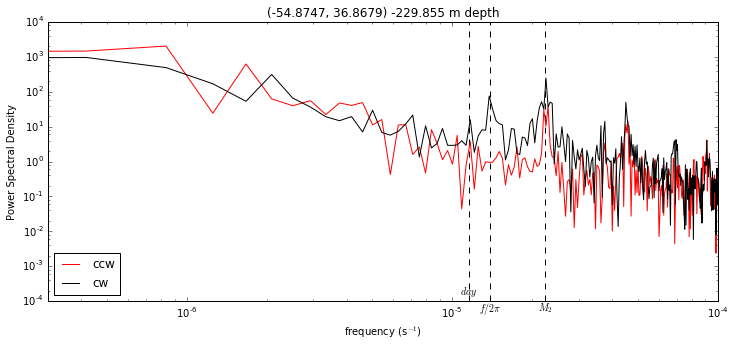

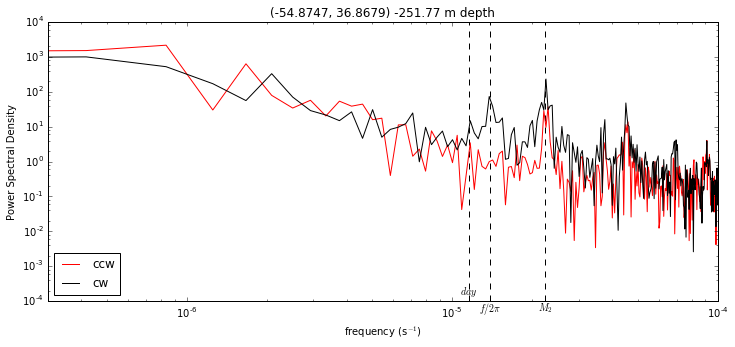

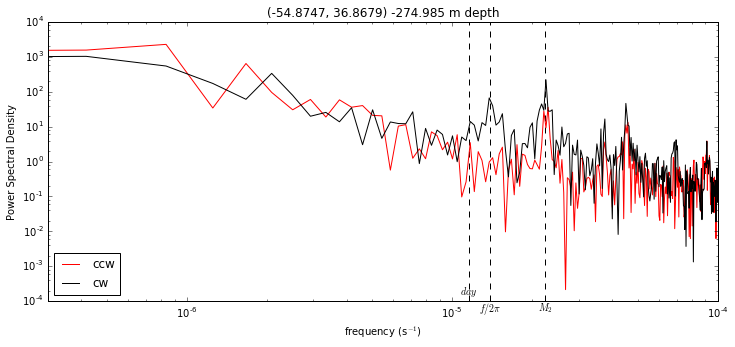

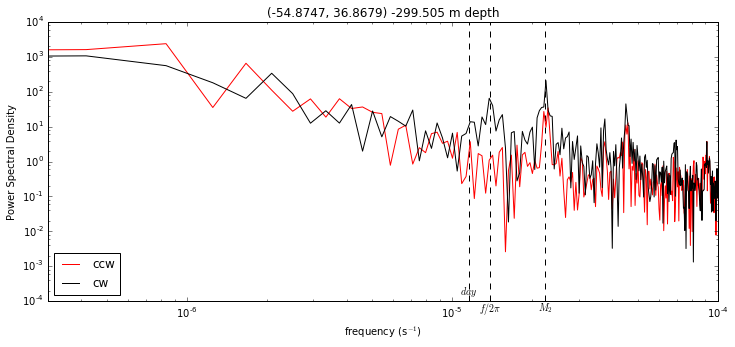

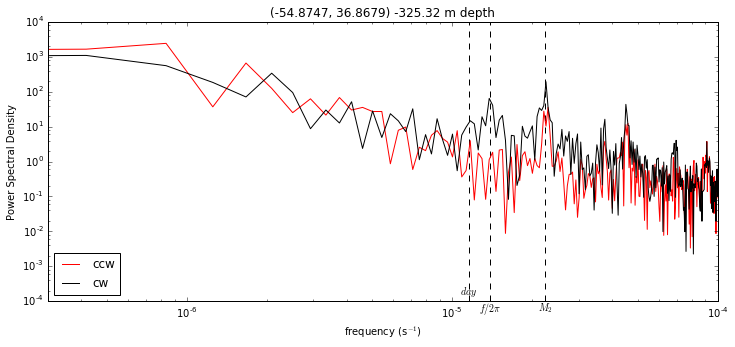

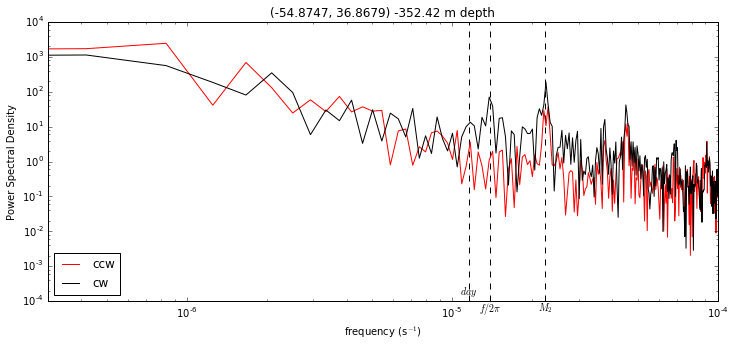

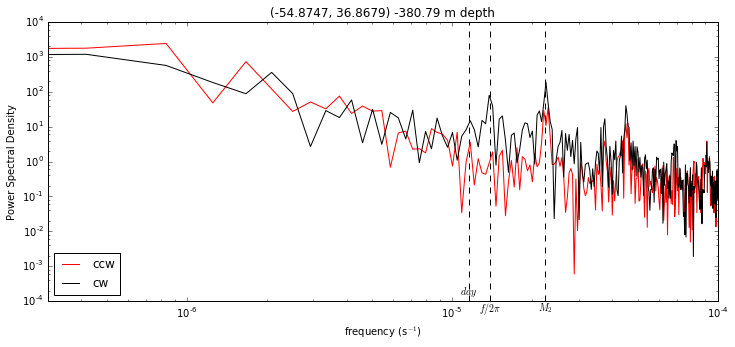

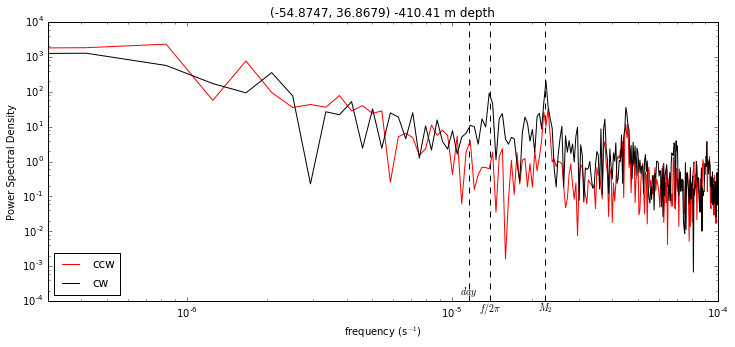

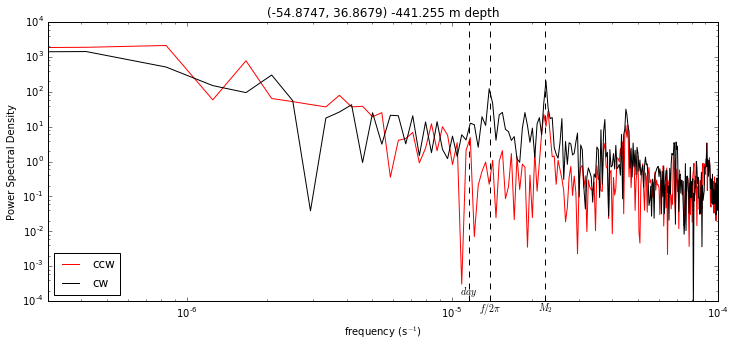

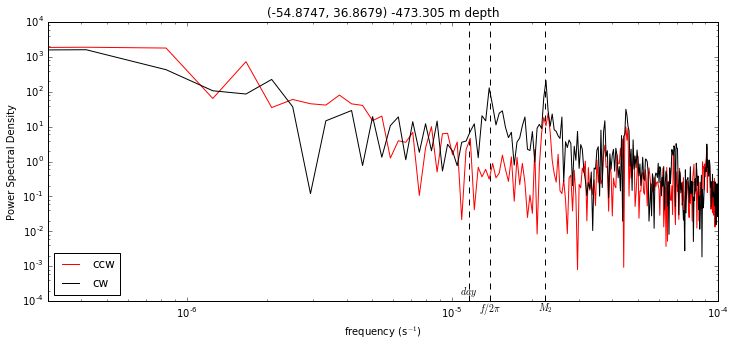

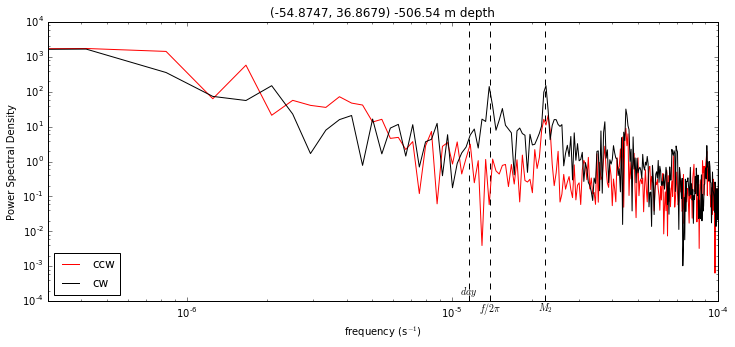

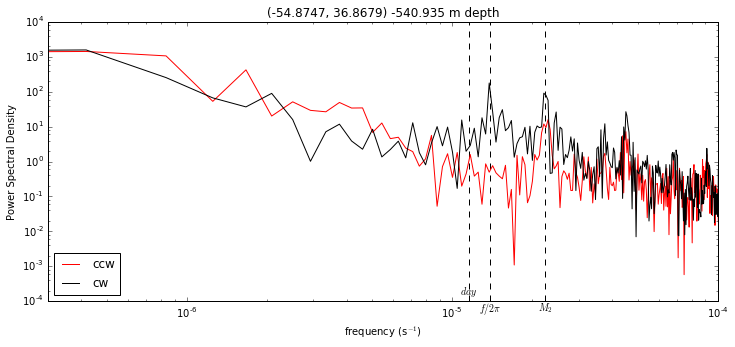

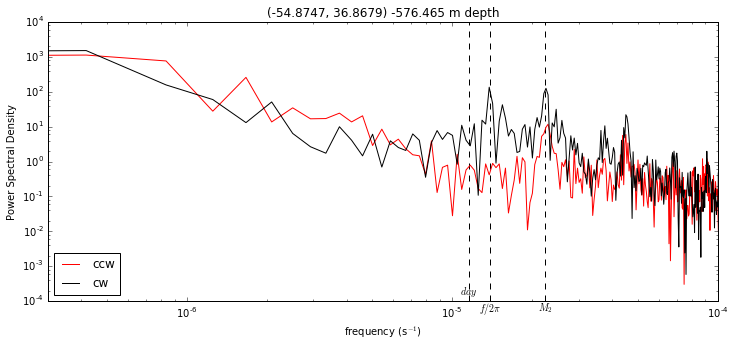

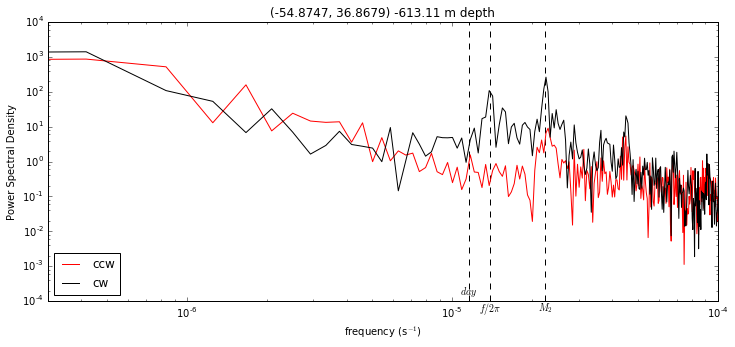

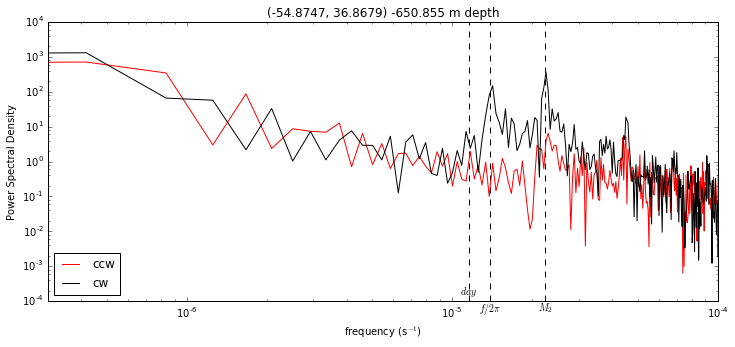

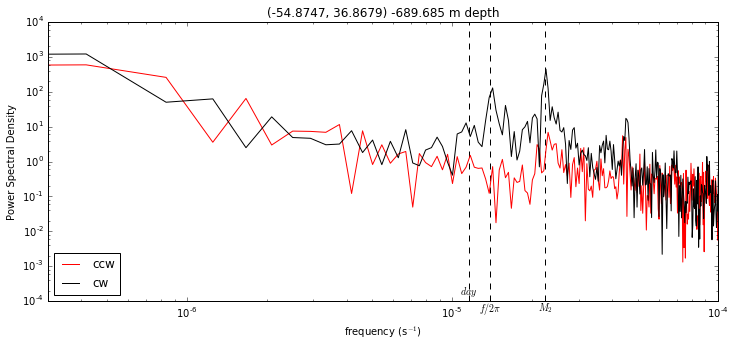

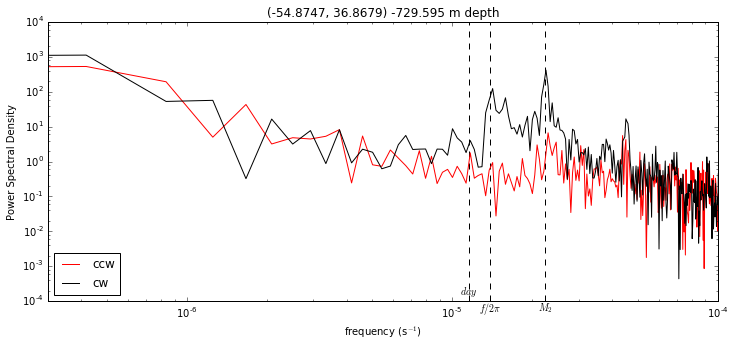

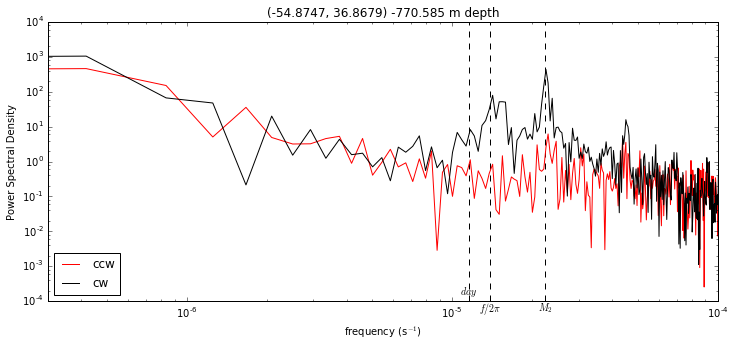

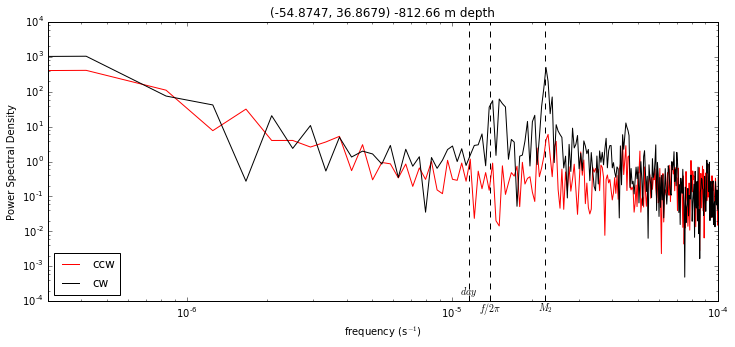

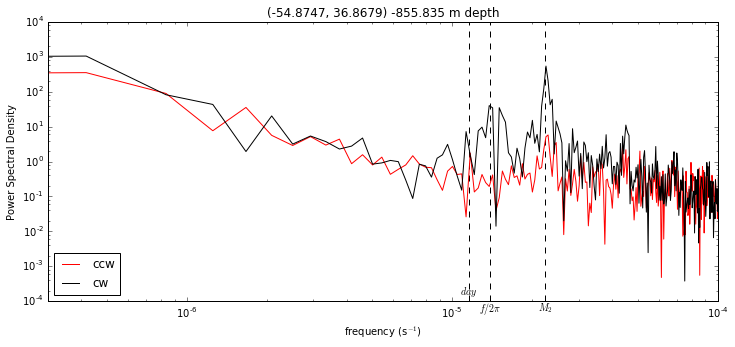

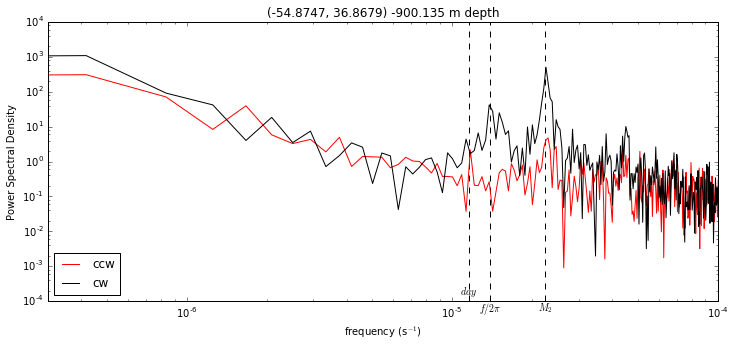

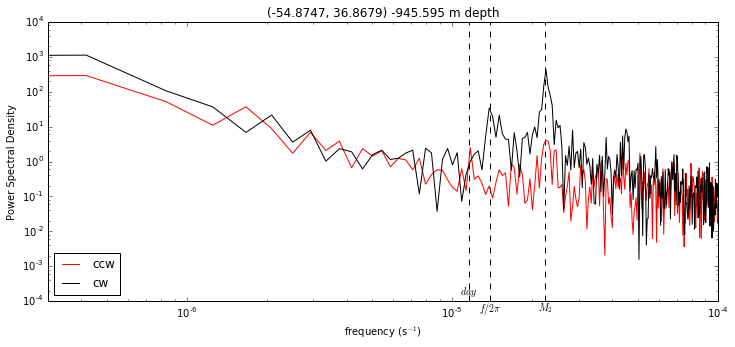

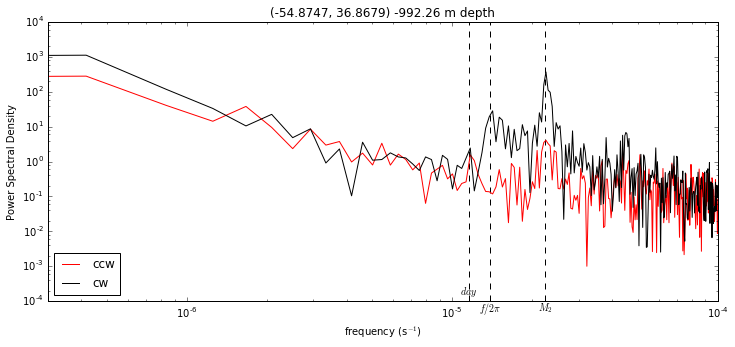

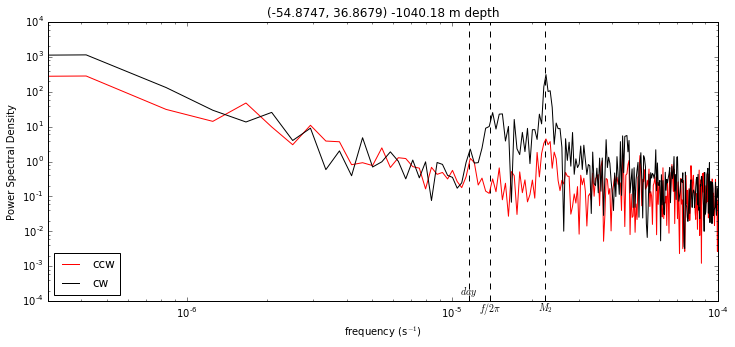

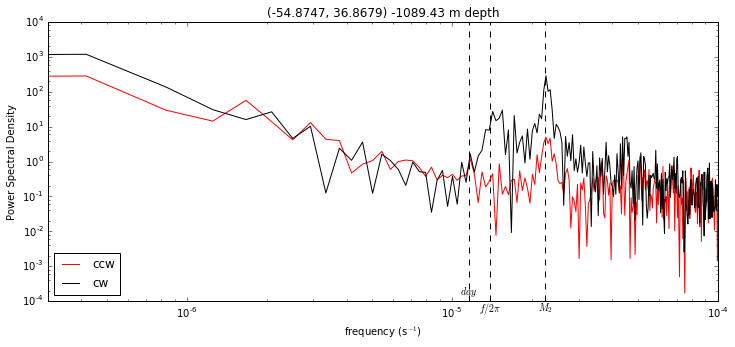

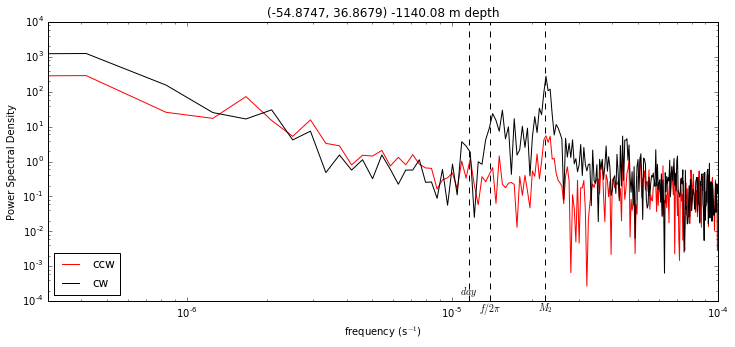

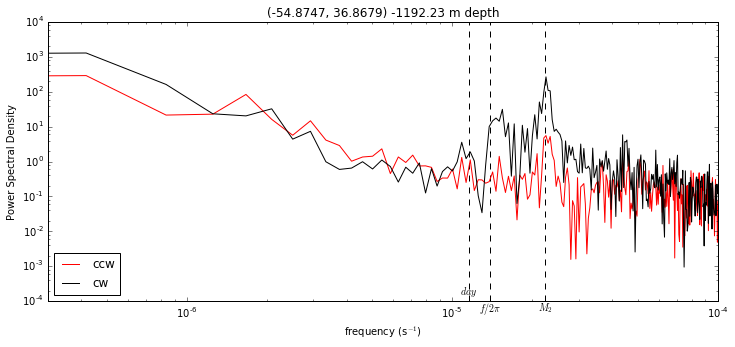

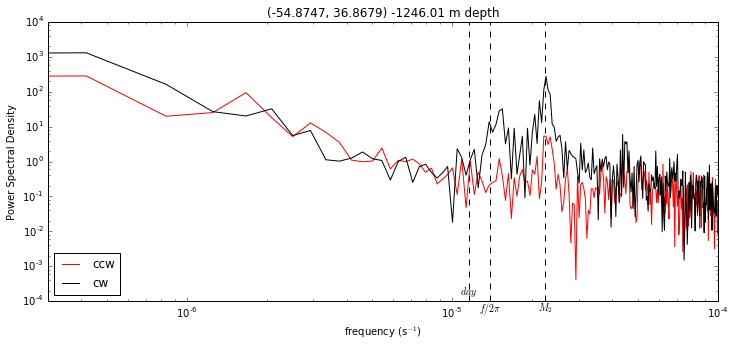

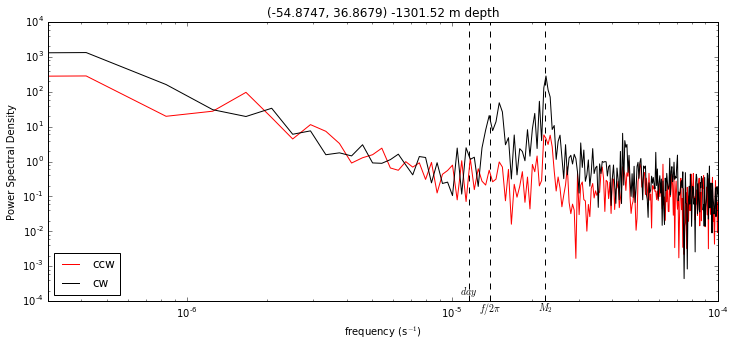

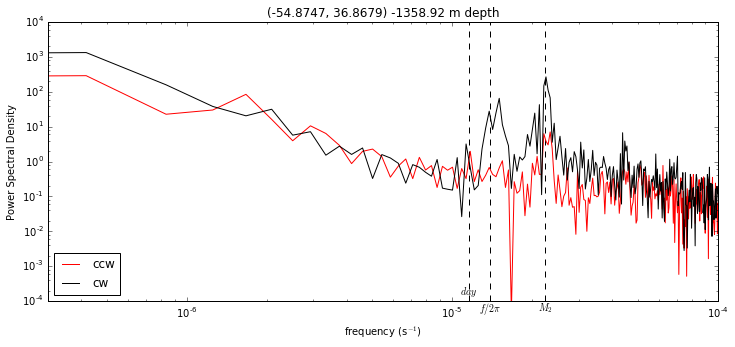

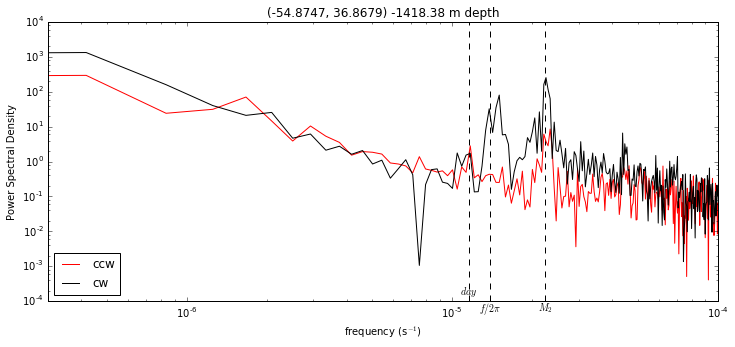

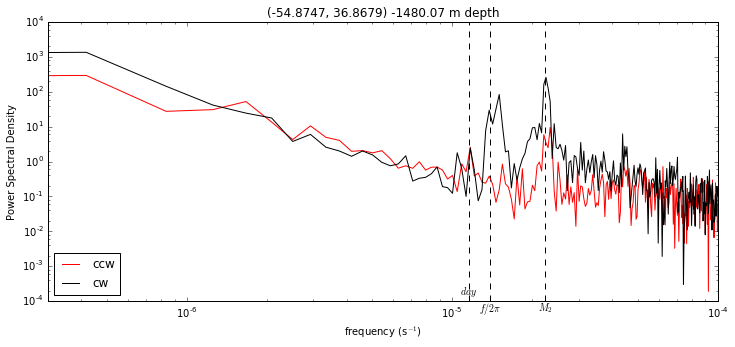

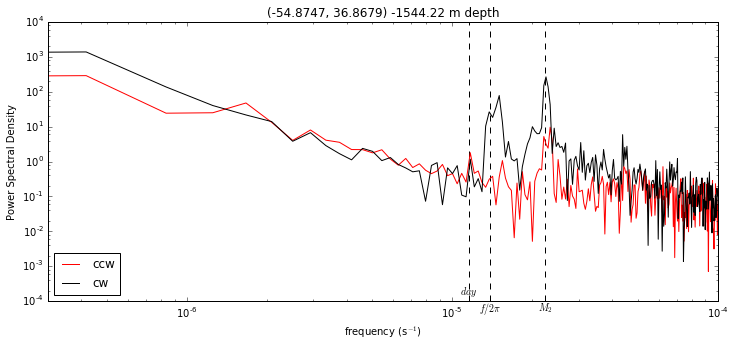

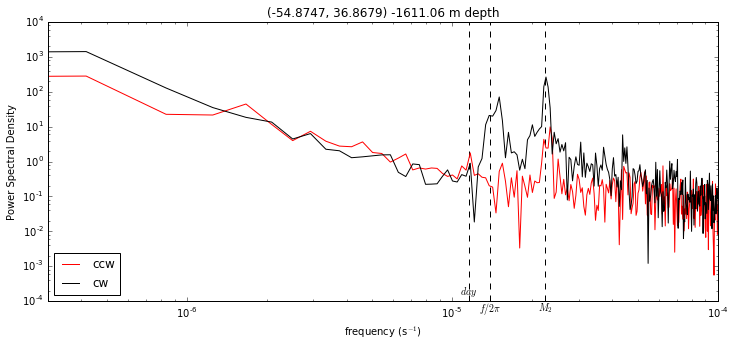

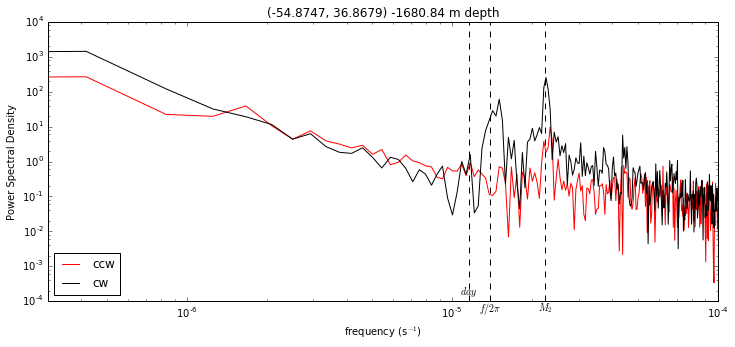

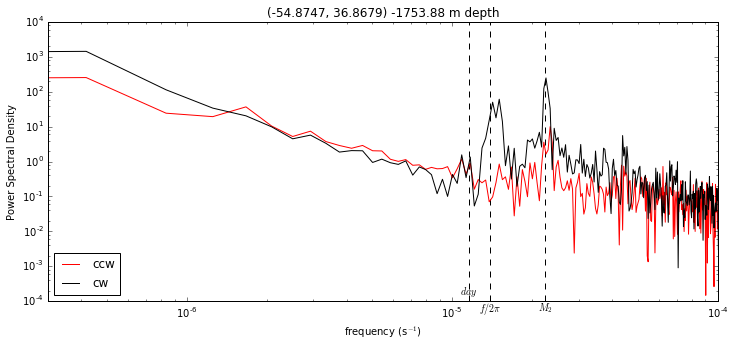

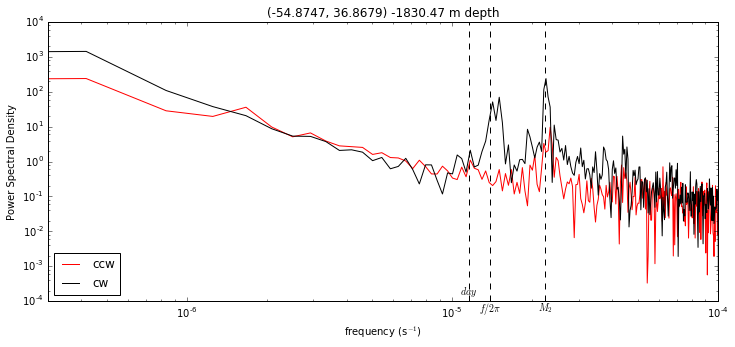

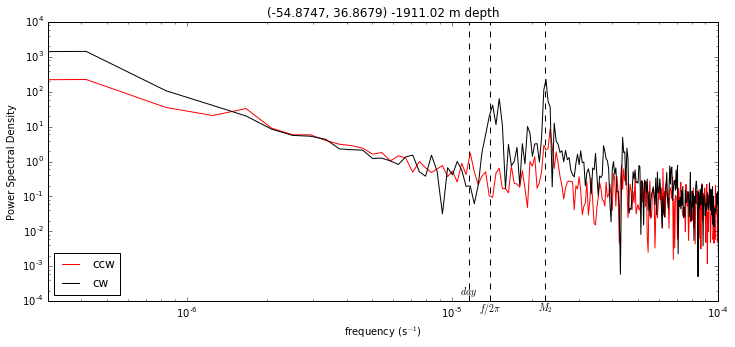

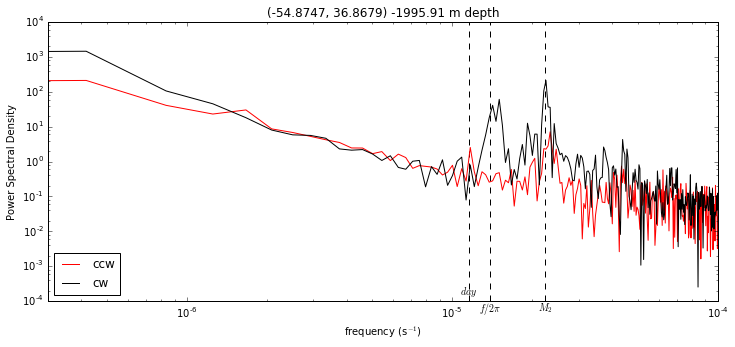

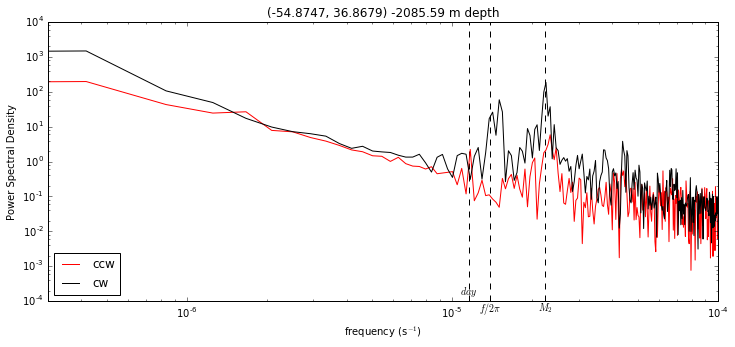

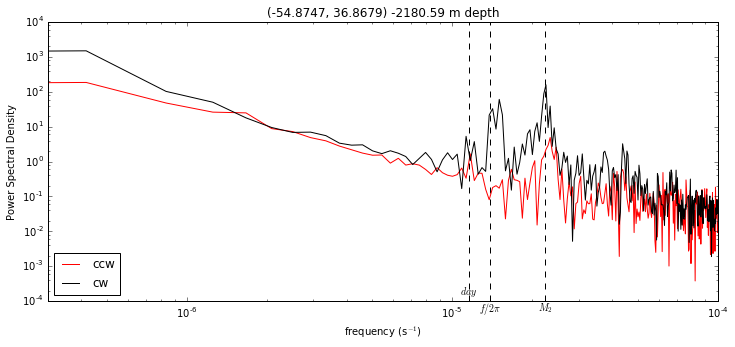

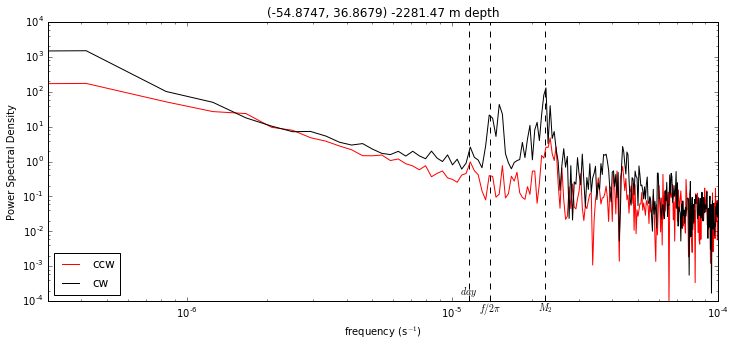

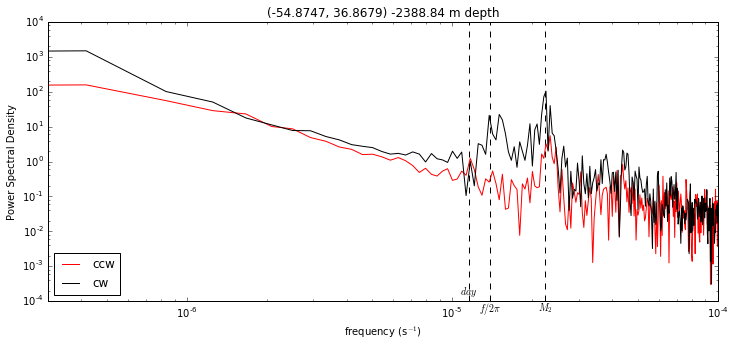

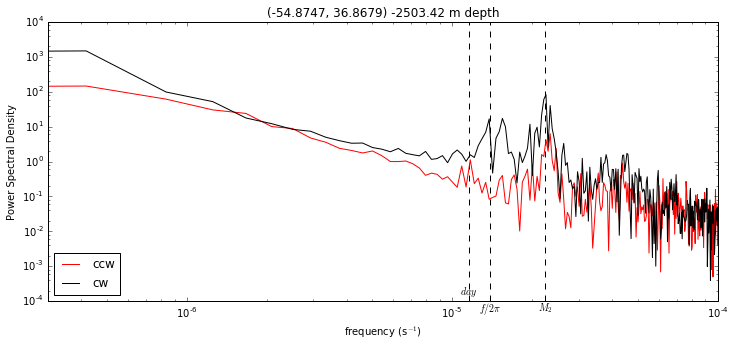

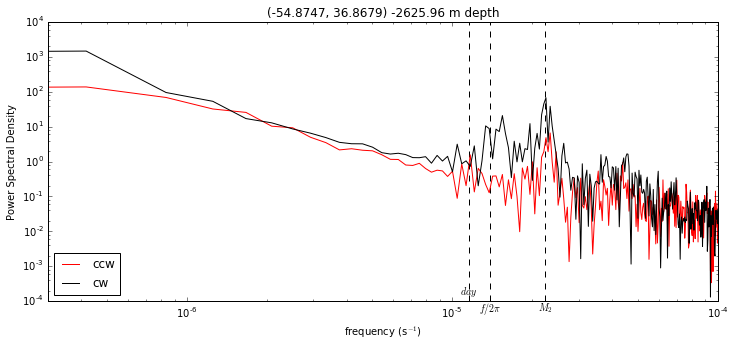

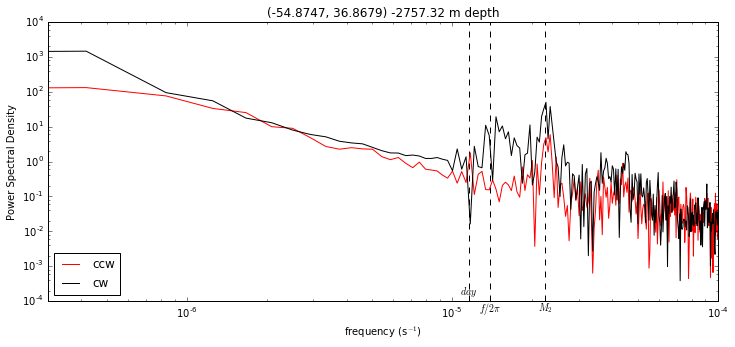

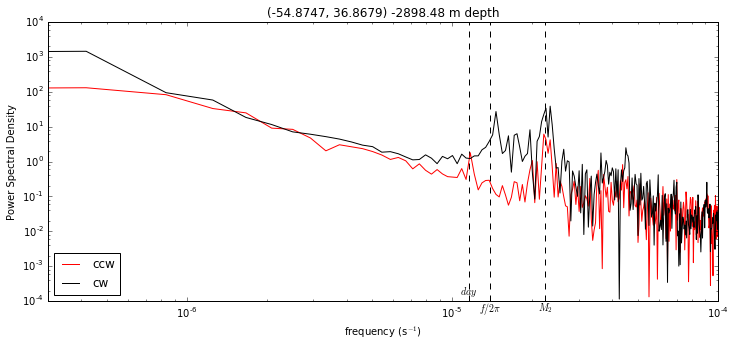

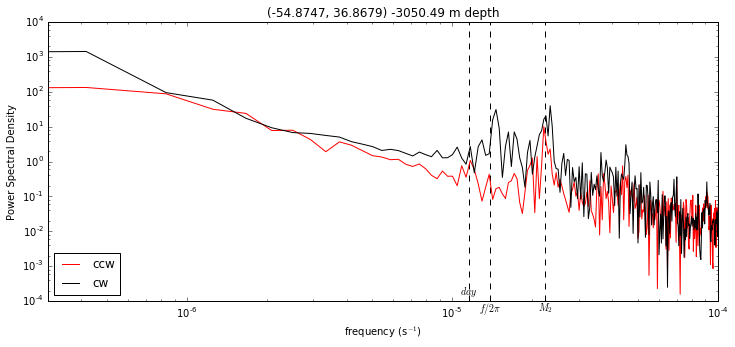

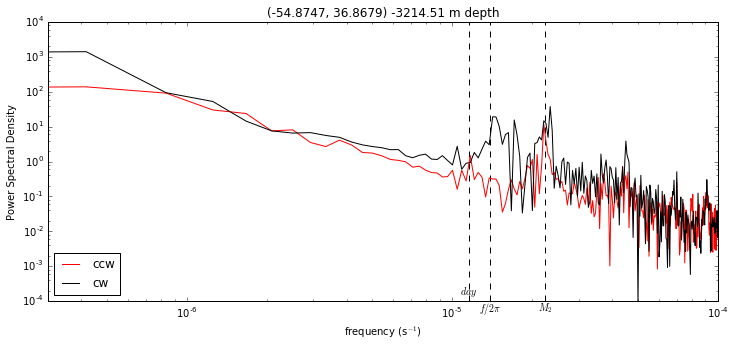

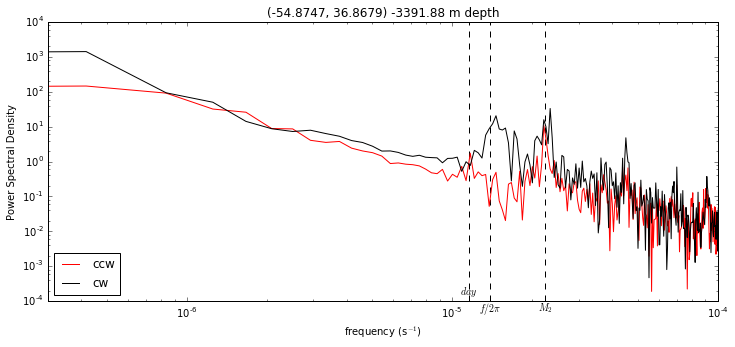

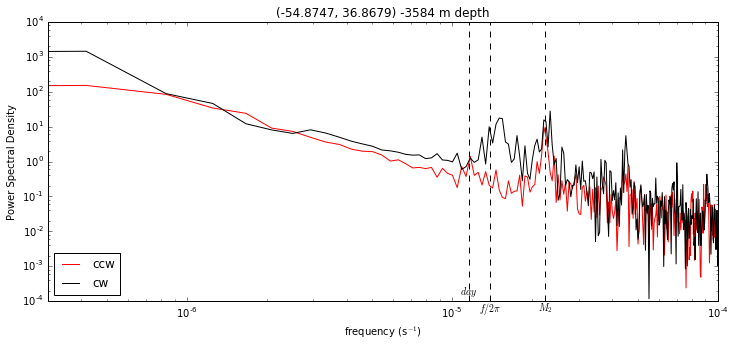

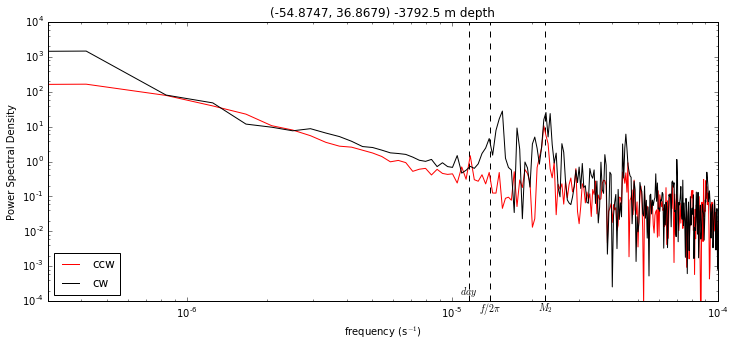

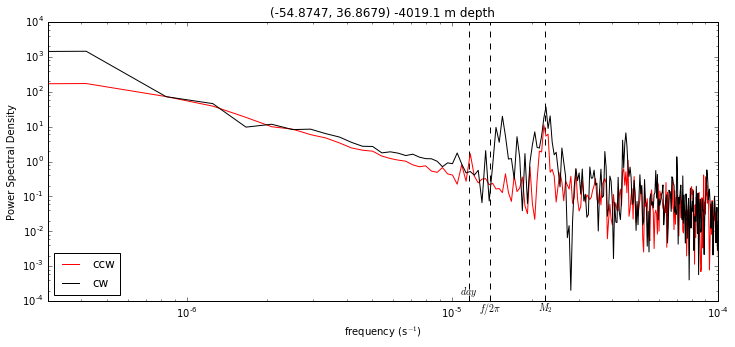

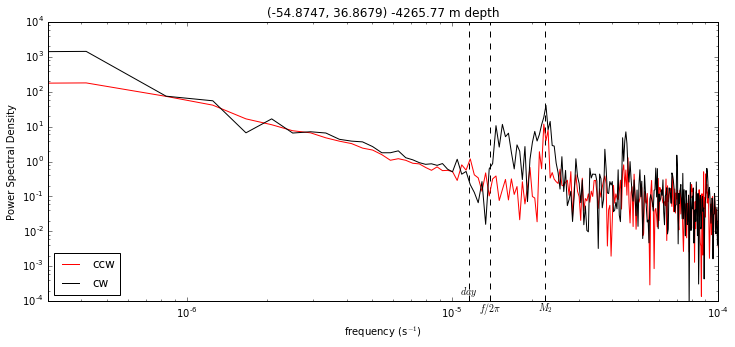

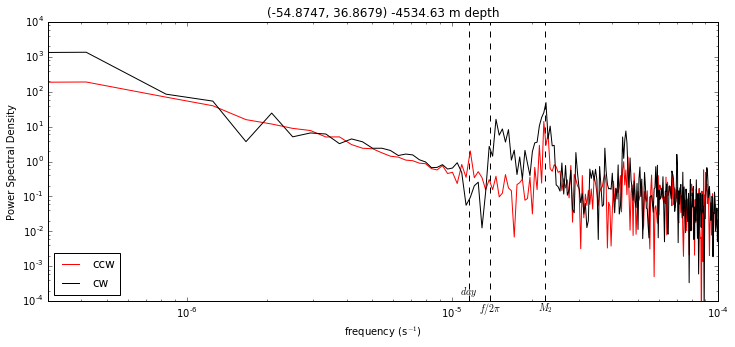

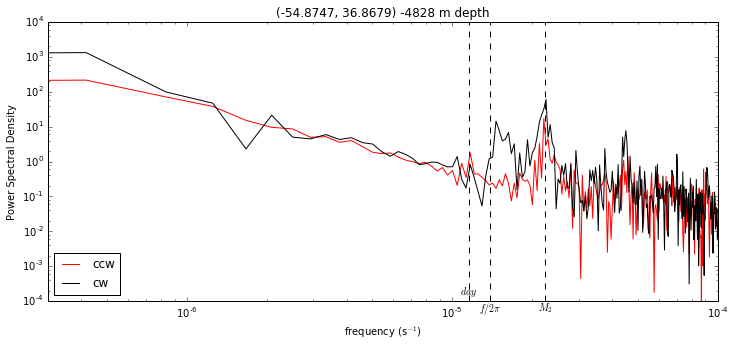

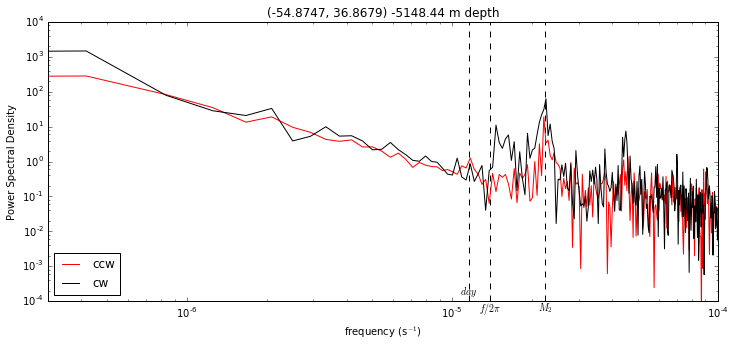

ValueError: Data has no positive values, and therefore can not be log-scaled.

In [7]:
mean_lat = np.asscalar(ds.yc.mean().values)
mean_lon = np.asscalar(ds.xc.mean().values)
omega = 7.2921e-5

f_freq = (2 * omega) * np.sin(np.radians(mean_lat)) / (2*np.pi)

m2_freq = (12.4206012 * (60*60))**-1

day_freq = (24*60*60.)**-1

hour_freq = (60*60.)**-1


for j in range(len(ds.rc)):
#for j in range(4):
    
    mean_depth = np.asscalar(ds.rc[j].values)
    # CCW rotation is positive frequency

    
    fig, ax = plt.subplots(figsize=(12,5))
    psd_ccw.isel(rc=j).plot(ax=ax, color='r', label='ccw')
    psd_cw.isel(rc=j).plot(ax=ax, color='k', label='cw')
    
    ax.set_xscale('log')
    ax.set_xlim(xlim)
    ax.set_yscale('log')
    ax.set_ylim(ylim)
    
    ax.legend(loc='lower left')
    
    ax.vlines([day_freq, f_freq, m2_freq], ylim[0], ylim[1], linestyle='dashed')

    ax.set_xlabel('frequency (s$^{-1}$)')
    ax.set_ylabel('Power Spectral Density')

    ax.text(f_freq, ylim[0], r'$f/2\pi$', ha='center', va='top')
    ax.text(m2_freq, ylim[0], r'$M_2$', ha='center', va='top')
    ax.text(day_freq, ylim[0]+2e-4, r'$day$', ha='center', va='top')
    ax.set_title('(%g, %g) %g m depth' % (mean_lon, mean_lat, mean_depth))
    fig.savefig(figdir+'PowerSpectralDensity_%03d' %j)

In [ ]:
def rotary_spectrum(ds):
    if np.any(np.isnan(ds.U)):
        raise ValueError("Gaps detected in u. Can't calculate power spectrum.")
    w = (ds.U + 1j * ds.V)
    dft = xrft.dft(w)
    psd = (dft * np.conj(dft)).astype('f8')
    winsize = int(len(psd)/500)
    psd_smooth = psd.rolling(freq_time=winsize, center=True).mean(dim='freq_time')
    psd_ccw = psd_smooth.sel(freq_time=slice(0, np.inf)).rename('ccw').to_dataset()
    psd_cw = psd_smooth.sel(freq_time=slice(-np.inf, 0)).rename('cw').to_dataset()
    psd_cw.freq_time.data *= -1
    return xr.merge([psd_ccw, psd_cw, ds])

def plot_rotary_spectrum(ds, ylim=[1e-1,1e5], xlim=[3e-7, 1e-4]):

    
    m2_freq = (12.4206012 * (60*60))**-1
    omega = 7.2921e-5
    mean_lat = np.asscalar(ds.Y.mean().values)
    mean_lon = np.asscalar(ds.X.mean().values)
    mean_depth = np.asscalar(ds.rc.mean().values)
    # CCW rotation is positive frequency
    f_freq = -(2 * omega) * np.sin(np.radians(mean_lat)) / (2.*np.pi)
    year_freq = (365*24*60*60.)**-1
    month_freq = (31*24*60*60.)**-1
    day_freq = (24*60*60.)**-1
    hour_freq = (60*60.)**-1
    
    fig, ax = plt.subplots(figsize=(12,4))
    ds.ccw.plot(ax=ax, color='r', label='ccw')
    ds.cw.plot(ax=ax, color='k', label='cw')
    
    ax.set_xscale('log')
    ax.set_xlim(xlim)
    ax.set_yscale('log')
    ax.set_ylim(ylim)
    
    ax.legend(loc='lower left')
    
    ax.vlines([f_freq, m2_freq], ylim[0], ylim[1], linestyle='dashed')

    ax.set_xlabel('frequency (s$^{-1}$)')
    ax.text(f_freq, ylim[0], r'$f/2\pi$', ha='center', va='top')
    ax.text(m2_freq, ylim[0], r'$M_2$', ha='center', va='top')
    ax.set_title('(%g, %g) %g m depth' % (mean_lon, mean_lat, mean_depth))

In [ ]:
for ds in dsets:
    try:
        rot_spec = rotary_spectrum(ds)
        plot_rotary_spectrum(rot_spec)
    except ValueError:
        pass